# Hopfield networks

See also:
- https://ml-jku.github.io/hopfield-layers/
- https://en.wikipedia.org/wiki/Hopfield_network 
- https://en.wikipedia.org/wiki/Modern_Hopfield_network
- https://arxiv.org/pdf/1702.01929.pdf (Modern Hopfield network paper)
- https://arxiv.org/abs/2008.06996 (Modern Hopfield network for continuous 

## Hopfield network on a single image

We want to encode a single state vector as the equilibrium of the spin system, which will represent a binarized image of Homer Simpson.

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
from dataclasses import dataclass
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('../resources/simpsons/bw/homer.jpg')

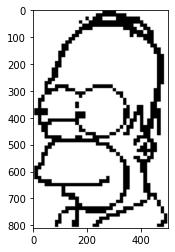

In [3]:
plt.imshow(img);

Here he is!

Use custom threshold to binarize the image and resize

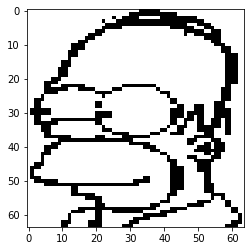

In [4]:
thresh = 118
fn = lambda x : 255 if x > thresh else 0
bw = img.convert('L').point(fn, mode='1')

size=64
r = bw.resize((size, size), Image.ANTIALIAS)

homer = 2*np.bitwise_not(np.array(r)) - 1

plt.imshow(homer, cmap='Greys');

In [5]:
homer.min(), homer.max()

(-1, 1)

In [6]:
homer.shape

(64, 64)

Encode Homer as a vector $x$ in the interaction strengths of the spins $W$.

In [7]:
homer_vec = homer.reshape((size*size, 1))

In [8]:
W = homer_vec.dot(homer_vec.transpose())

Now take an initial state $\xi$ as some corrupted image of Homer (we could start with any vector because $x$ will turn out to be a global attractor).

In [9]:
initial_state = homer_vec.copy()
initial_state[int(size*size/2):] = 1

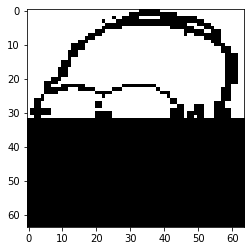

In [10]:
plt.imshow(initial_state.reshape((size, size)), cmap='Greys')

We can evolve the image in one shot to the system equilibrium.

In [11]:
final_state = np.sign(W.dot(initial_state))

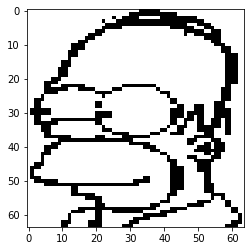

In [12]:
plt.imshow(final_state.reshape((size,size)), cmap='Greys');

We got the same image.

## Hopfield network on multiple images

Things get interesting if we want to encode $N$ images.

In [13]:
from pathlib import Path

In [14]:
simpsons = list(Path('../resources/simpsons/bw').glob('*'))
simpsons = {f.stem: f for f in simpsons}

In [15]:
simpsons

{'abe': PosixPath('../resources/simpsons/bw/abe.jpg'),
 'bart': PosixPath('../resources/simpsons/bw/bart.jpg'),
 'homer': PosixPath('../resources/simpsons/bw/homer.jpg'),
 'lisa': PosixPath('../resources/simpsons/bw/lisa.jpg'),
 'maggie': PosixPath('../resources/simpsons/bw/maggie.jpg'),
 'marge': PosixPath('../resources/simpsons/bw/marge.jpg'),
 'moe': PosixPath('../resources/simpsons/bw/moe.jpg')}

In [16]:
def threshold_square_vectorize(file, thresh, size):
    img = Image.open(file)
    fn = lambda x : 255 if x > thresh else 0
    bw = img.convert('L').point(fn, mode='1')
    r = bw.resize((size, size), Image.ANTIALIAS)
    return 2*np.bitwise_not(np.array(r)) - 1


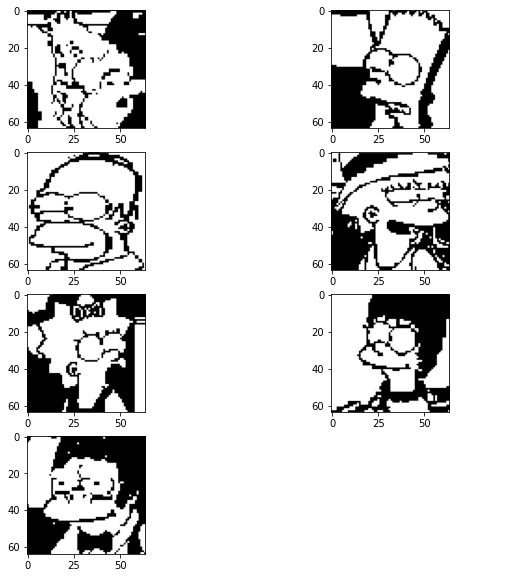

In [17]:
thresh = {'bart': 200, 'homer': 118, 'lisa': 200, 'marge': 170, 'abe': 120, 'moe': 120, 'maggie': 120}
names = []
vectors = []
size = 64

fig, axs = plt.subplots(4, 2, figsize=(10,10))
axs = axs.ravel()

for i, simpson in enumerate(simpsons):
    v = threshold_square_vectorize(simpsons[simpson], thresh[simpson], size)
    state_vector = v.reshape(size*size)
    names.append(simpson)
    vectors.append(state_vector)
    
    ax = axs[i]
    ax.imshow(v, cmap='Greys')

axs[-1].axis(False);

state_vectors = pd.DataFrame(np.stack(vectors, axis=1), columns=names)

In [18]:
state_vectors

,abe,bart,homer,lisa,maggie,marge,moe
0,1,1,-1,-1,-1,-1,1
1,1,1,-1,-1,-1,-1,1
2,1,1,-1,-1,-1,-1,1
3,1,1,-1,-1,-1,-1,-1
4,1,1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
4091,1,-1,1,1,-1,1,1
4092,1,-1,1,-1,-1,1,1
4093,1,-1,1,-1,-1,1,-1
4094,1,-1,-1,1,-1,1,-1


In [19]:
def _subset_state_vectors(state_vectors, names):
    if names is None:
        return state_vectors.values.copy()
    else:        
        return state_vectors.loc[:, names].values.copy()

def compute_interaction_weights(state_vectors, names = None):
    sv = _subset_state_vectors(state_vectors, names)
    return np.einsum('ij,kj', sv, sv)

In [20]:
def plot_img_vec(vec, size):
    plt.imshow(vec.reshape((size,size)), cmap='Greys');

In [21]:
def update_state_from_interactions(state, W):
    return np.sign(W.dot(state))

In [22]:
W_all = compute_interaction_weights(state_vectors, ['homer','lisa','lisa'])

In [23]:
final_state = update_state_from_interactions(initial_state, W_all)

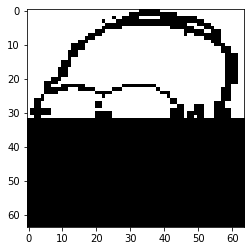

In [24]:
plot_img_vec(initial_state, size)

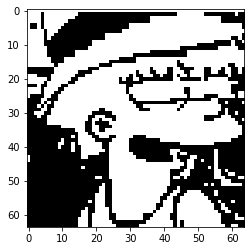

In [25]:
plot_img_vec(final_state, size)

Retrieval is no longer perfect.

In [26]:
W_all = compute_interaction_weights(state_vectors, ['homer', 'homer', 'lisa'])

In [27]:
final_state = update_state_from_interactions(initial_state, W_all)

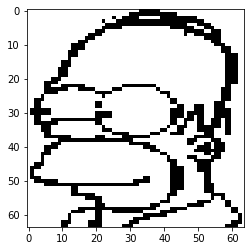

In [28]:
plot_img_vec(final_state, size)

But if we encode the system more heavily with Homer, we still get Homer back. Note also that, since we've used $U=0$, both +1 and -1 have the same energy, so we can get the inverse image back too.

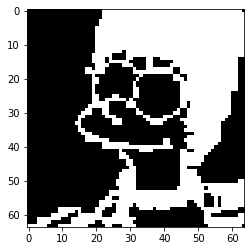

In [29]:
W_all = compute_interaction_weights(state_vectors, ['homer', 'marge', 'marge'])
final_state = update_state_from_interactions(initial_state, W_all)
plot_img_vec(final_state, size)

Try using 6 patterns:

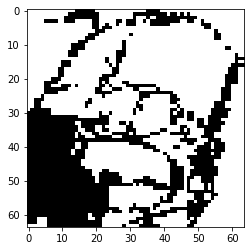

In [30]:
W_all = compute_interaction_weights(state_vectors, ['homer', 'bart', 'marge', 'maggie', 'abe', 'moe'])
final_state = update_state_from_interactions(initial_state, W_all)
plot_img_vec(final_state, size)

The retrieval is all mashed up.

One might suspect that the limited capacity of the network is the explanation for the imperfect retrieval. However, it [can be shown](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.322.3548&rep=rep1&type=pdf) that the maximum number of patterns which can be stored in a Hopfield network with perfect retrieval ($C$) is
$$C \approx \frac{d}{2 \log(d)}$$
and with imperfect retrieval is
$$C \approx 0.14 d$$
which for the case of 64$\times$64 images is $C=573$ images.

Capacity is not the explanation, it is that the images are correlated. Thus we need a method which can pull apart strongly correlated patterns.

## Modern Hopfield Networks (a.k.a. Dense Associative Memories)

Modern hopfield networks generalise the Hopfield network, and can improve upon the linear scaling of number of memories with the number of neurons. The key theoretical idea is to use an energy function which is more sharply peaked around the stored memories in neuronal configuration space, relative to the classical Hopfield network.

In [31]:
from scipy.special import logsumexp
from typing import Optional
from tqdm import tqdm

In [32]:
def exponential_interaction_function(update_index, sv: np.array, initial_state: np.array):    
    d = initial_state.shape[0]
    n_mem = sv.shape[1]     
    
    assert sv.shape == (d, n_mem)
    assert initial_state.shape == (d, 1)
    
    
    initial_state_flip = initial_state.copy()
    initial_state_flip[update_index] = - initial_state_flip[update_index]
    
    proj_init_state_no_flip = sv.transpose().dot(initial_state)
    proj_init_state_flip = sv.transpose().dot(initial_state_flip)
    
    log_energy_no_flip = logsumexp(proj_init_state_no_flip)  # the exp here is the key, to achieve peakiness in configuration space
    log_energy_flip    = logsumexp(proj_init_state_flip)       
    
    if log_energy_flip < log_energy_no_flip:  # if energy with flip is lower than energy without flip
        return -1 * initial_state_flip[update_index]  # then flip
        # return -1  # the original paper seems to suggest it should be this
    else:
        return initial_state_flip[update_index]  # don't flip
        # return 1  # the original paper seems to suggest it should be this

def modern_hopfield_update_exp(initial_state: np.array, state_vectors: pd.DataFrame, names:  Optional[list] = None): 
    state_update = initial_state.copy()    
    sv = _subset_state_vectors(state_vectors, names)
    for i in tqdm(range(initial_state.shape[0])):
        new_state = exponential_interaction_function(i, sv, initial_state)
        state_update[i] = new_state        
    return state_update

**Note**: Here, I'm **updating** the input state state by determining whether or not to flip the state, whereas [the wikipedia page](https://en.wikipedia.org/wiki/Modern_Hopfield_network) and [the original paper](https://arxiv.org/pdf/1702.01929.pdf) say that the update rule sets the absolute state of the neuron ($V_i^{(t+1)} = \text{sign}[...]$). I'm not completely sure where the difference is arising, but what I do above works.

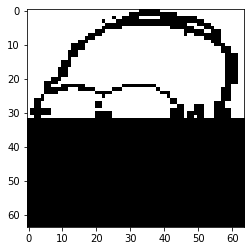

In [33]:
plot_img_vec(initial_state, size)

100%|██████████| 4096/4096 [00:00<00:00, 7987.22it/s]


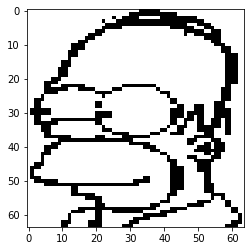

In [34]:
final_state = modern_hopfield_update_exp(initial_state, state_vectors, names=['homer', 'bart', 'marge', 'maggie', 'abe', 'moe'])
plot_img_vec(final_state, size)

The modern Hopfield network can retrieve Homer, even with all 6 images stored. Modern Hopfield networks can distinguish strongly correlated patterns, and have much-increased storage capacity, [see here](https://ml-jku.github.io/hopfield-layers/).

## Energy function for continuous-valued patterns and states

In [this paper](https://arxiv.org/abs/2008.06996) it can be shown that the energy function

$$E = -\text{logsumexp}(\beta, X^T \xi) + \frac{1}{2} \xi^T \xi + \beta^{-1} \log N + \frac{1}{2} M^2$$

has the update rule

$$\xi^{t+1} = X \text{softmax}(\beta X^T \xi^t)$$

which can be used for continuous patterns and states. The energy function has the properties:

1. Global convergence to a local minimum (i.e. one of the stored patterns)
1. Exponential storage capacity
1. Convergence after one update step

Use greyscale images and implement the softmax update rule.

In [35]:
simpsons_paths = list(Path('../resources/simpsons/gs/').glob('*'))

In [36]:
simpson_vectors_gs = {}
for simpson in simpsons_paths:
    name = simpson.stem
    img = Image.open(simpson).convert('L')
    r = img.resize((size, size), Image.ANTIALIAS)
    state_vector = np.array(r).reshape(size*size)
    simpson_vectors_gs[name] = 255 - state_vector
simpson_vectors_gs = pd.DataFrame(simpson_vectors_gs)

# need to standardize the input or the softmax will mean that you end up matching on pixel intensity rather than the pattern
simpson_vectors_gs = (simpson_vectors_gs - simpson_vectors_gs.mean(axis=0)) / simpson_vectors_gs.std(axis=0)  

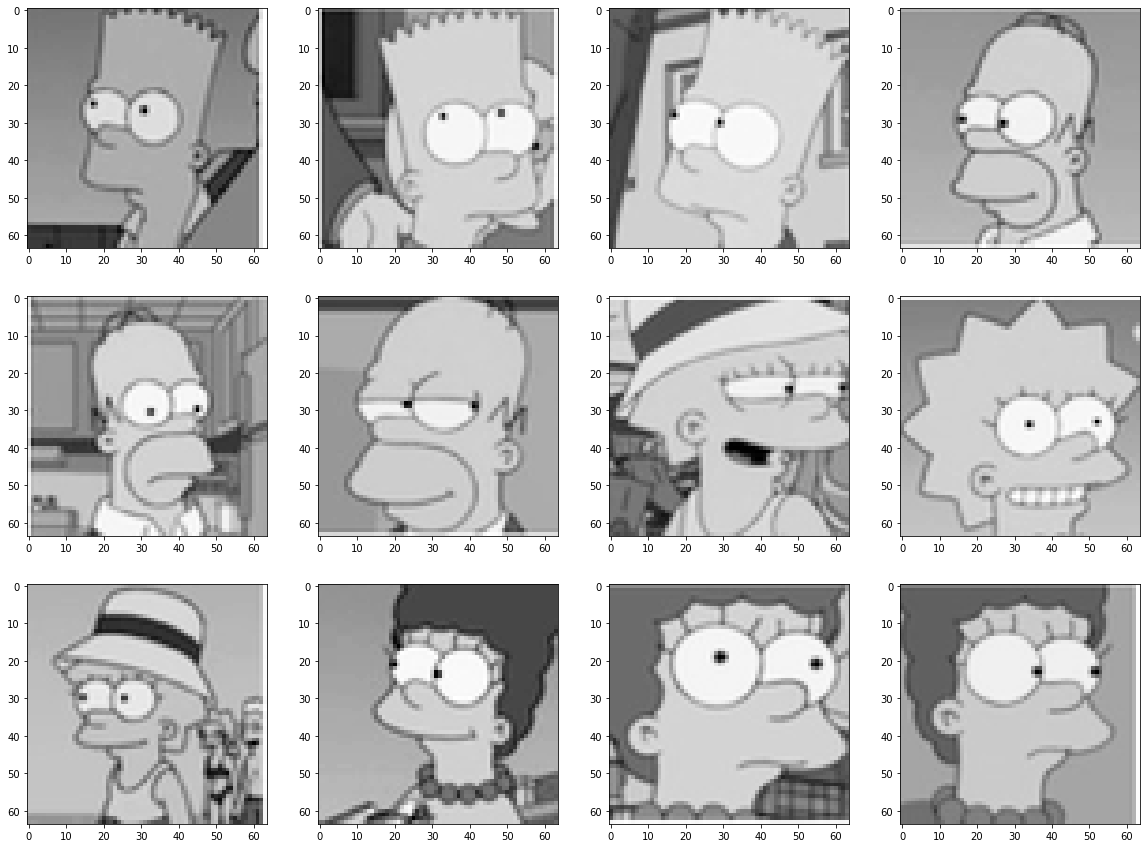

In [37]:
fig, axs = plt.subplots(3,4,figsize=(4*5, 3*5))
axs = axs.ravel()
for i, s in enumerate(simpson_vectors_gs.columns):
    ax = axs[i]
    state_vector = simpson_vectors_gs.loc[:, s].values
    ax.imshow(state_vector.reshape((size,size)), cmap='Greys');

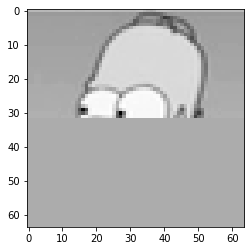

In [38]:
initial_state = simpson_vectors_gs['homer1'].values.copy().reshape((size*size,1))
initial_state[int(size*size*0.5):] = 0.5
plot_img_vec(initial_state, size)

In [44]:
def softmax(x: np.array):    
    x = x.astype(np.float)
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

def hopfield_continuous_softmax_update(state_vectors: pd.DataFrame, initial_state: np.array, names: Optional[str] = None, beta: float = 1):
    sv = _subset_state_vectors(state_vectors, names)    
    
    sv = sv.astype(float)
    initial_state = initial_state.astype(float)
        
    d = initial_state.shape[0]
    n_mem = sv.shape[1]     
    
    assert sv.shape == (d, n_mem)
    assert initial_state.shape == (d, 1)
    
    probs = softmax(beta * sv.transpose().dot(initial_state)).reshape(n_mem, 1)
    return sv.dot(probs)

In [45]:
sv = simpson_vectors_gs.values.astype(float)

In [46]:
final_state = hopfield_continuous_softmax_update(simpson_vectors_gs, initial_state)

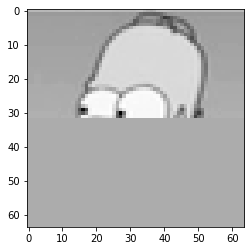

In [47]:
plot_img_vec(initial_state, size)

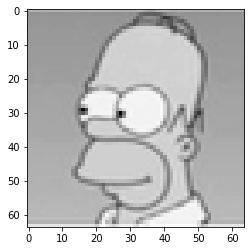

In [48]:
plot_img_vec(final_state, size)

We got Homer!

The $\beta$ parameter is an inverse temperature, and determines how separated the fixed points are. Lowering $\beta$ creates metastable states.

In [67]:
final_state = hopfield_continuous_softmax_update(simpson_vectors_gs, initial_state, beta = 1e-3)

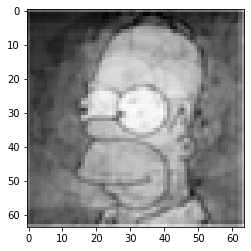

In [68]:
plot_img_vec(final_state, size)

It's now more smooshed.

In [69]:
final_state2 = hopfield_continuous_softmax_update(simpson_vectors_gs, final_state, beta = 1e-3)